# `RealSim-CFIS`

In this doc I build the functionality for a version of `RealSim` that specifically deals with the Canada-France Imaging Survey.

## Atmospheric attenuation analysis

### Starting with the SDSS filter response functions

Here I investigate the atmospheric affects on the SDSS filter response functions in preparation for implementation in the Realism suite and for application of findings to the CFIS image generation. I found where the "Doi and Annis" response curves were. They appear to be incorrect, as I had suspected. I suggest updating files to use the Doi et al (2010) filter response results found here: http://classic.sdss.org/dr7/instruments/imager/index.html#filters. 

In addition to the unattenuated and attenuated responses, this update enables scaling of the atmospherically attunuated curves by the normalization in the unattenuated case. The idea was to incorporate atmospheric effects into the curves but maintain an effective zero-airmass normalization while the normalization itself can be accounted for in post-processing (e.g. when using the real airmass from an image to insert into into a Field).

(2500, 11500)

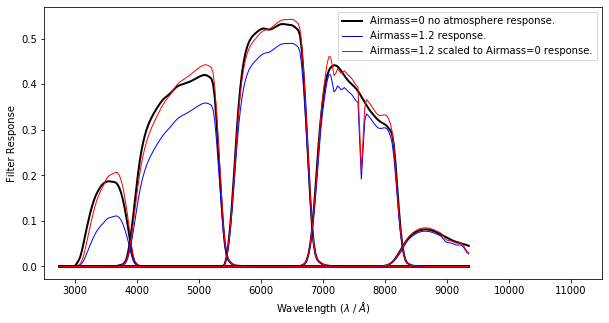

In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt


# filter response functions from Doi et al (2010)
# found http://classic.sdss.org/dr7/instruments/imager/index.html#filters
sdss_filters = 'Sources/utils/CFIS-cfg/SDSS_Photometry/'
# configuration path (SEx params, gim2d files, etc.)
sdss_cfg_path = 'Sources/utils/CFIS-cfg/SDSS_Photometry/'
# target redshift
redshift = 0.1
airmass=1.2

# wavelength list from SKIRT
wl_filename = sdss_cfg_path+'SDSS_gri3_wavelength_grid.dat'
# bands in which to produce photometry
bands = ['u','g','r','i','z']

# useful constants / quantities
speed_of_light = 2.998e8 # [m/s]
speed_of_light = speed_of_light*1e10 # [Angstrom/s]

# wavelengths of datacube [microns] (expand by redshift factor)
wl = np.loadtxt(wl_filename).astype(float)*1e4*(1+redshift) # [Angstrom]
# wavelength bin widths [Angstrom]
dwl = np.median(np.diff(wl)) # [Angstrom]

# set up figure
fig,ax = plt.subplots(figsize=(10,5))
ax.set_xlabel(r'Wavelength ($\lambda$ / $\AA$)')
ax.set_ylabel('Filter Response')

for band in bands:

    filter_data = np.loadtxt(sdss_filters+'{}.dat'.format(band))
    filter_wl = filter_data[:,0]
    filter_res = filter_data[:,3]
    filter_res = np.interp(xp=filter_wl,x=wl,fp=filter_res,left=0,right=0) # unitless
    norm_zeroair = np.trapz(filter_res,wl)
    plt.plot(wl,filter_res,color='black',linewidth=2,linestyle='solid',
            label=('Airmass=0 no atmosphere response.' if band is 'r' else None))
    
    # filter response function (w/ atmospheric effects but renormalized)
    filter_data = np.loadtxt(sdss_filters+'{}.dat'.format(band))
    filter_wl = filter_data[:,0]
    # extinction values in column 4 assume an airmass of 1.0
    #plt.plot(filter_wl,filter_data[:,4])
    kk = -2.5*np.log10(filter_data[:,4])
    correction = 10**(-0.4*(airmass*kk))
    filter_res = filter_data[:,3]*correction
    filter_res = np.interp(xp=filter_wl,x=wl,fp=filter_res,left=0,right=0) # unitless
    norm_air = np.trapz(filter_res,wl)
    plt.plot(wl,filter_res,color='blue',linewidth=1,linestyle='solid',
            label=('Airmass={} response.'.format(airmass) if band is 'r' else None))
    
    # filter response function (w/ atmospheric effects but renormalized)
    filter_data = np.loadtxt(sdss_filters+'{}.dat'.format(band))
    filter_wl = filter_data[:,0]
    kk = -2.5*np.log10(filter_data[:,4])
    correction = 10**(-0.4*(airmass*kk))
    filter_res = filter_data[:,3]*correction*norm_zeroair/norm_air
    filter_res = np.interp(xp=filter_wl,x=wl,fp=filter_res,left=0,right=0) # unitless
    
    plt.plot(wl,filter_res,color='red',linewidth=1,linestyle='solid',
             label=('Airmass={} scaled to Airmass=0 response.'.format(airmass) if band is 'r' else None))
    
ax.legend()
ax.set_xlim(2500,11500)
    


## CFIS filters

### Particularities

The CFIS filter curves already incorporate an airmass of 1.25 and corresponding extinction. Consequently, I must use the extinction function $k(\lambda)$ to back-out an airmass=0 filter curve. This is shown below. Coloured lines correspond to airmass=0 filter curves and solid lines correspond to the default airmass=1.25. Notice, however, that $k(\lambda)$ is not sufficiently resolved that I can remove the strong atmospheric absorption feature in the $i$-band. Nonetheless, the effects on the other bands are removed nicely.

(2500, 11500)

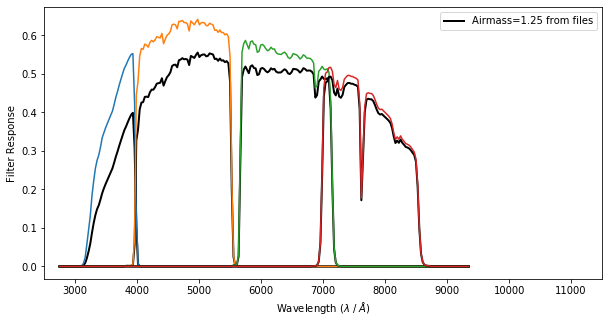

In [3]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt


# configuration path (SEx params, gim2d files, etc.)
cfis_cfg_path = 'Sources/utils/CFIS-cfg/CFIS_Photometry/'
# target redshift
redshift = 0.1
airmass=1.2

# wavelength list from SKIRT
wl_filename = cfis_cfg_path+'SKIRT_wavelength_grid.dat'
# bands in which to produce photometry
bands = ['u','g','r','i']

# useful constants / quantities
speed_of_light = 2.998e8 # [m/s]
speed_of_light = speed_of_light*1e10 # [Angstrom/s]

# wavelengths of datacube [microns] (expand by redshift factor)
wl = np.loadtxt(wl_filename).astype(float)*1e4*(1+redshift) # [Angstrom]
# wavelength bin widths [Angstrom]
dwl = np.median(np.diff(wl)) # [Angstrom]

# set up figure
fig,ax = plt.subplots(figsize=(10,5))
ax.set_xlabel(r'Wavelength ($\lambda$ / $\AA$)')
ax.set_ylabel('Filter Response')

for band in bands:

    filter_data = np.loadtxt(cfis_cfg_path+'{}_CFIS.res'.format(band.capitalize()))
    filter_wl = filter_data[:,0]
    filter_res = filter_data[:,1]
    filter_res = np.interp(xp=filter_wl,x=wl,fp=filter_res,left=0,right=0) # unitless
    norm_zeroair = np.trapz(filter_res,wl)
    plt.plot(wl,filter_res,color='black',linewidth=2,linestyle='solid',
            label=('Airmass=1.25 from files' if band is 'r' else None))
    
    # filter response function (w/ atmospheric effects but renormalized)
    filter_data = np.loadtxt(cfis_cfg_path+'{}_CFIS.res'.format(band.capitalize()))
    filter_wl = filter_data[:,0]
    filter_res = filter_data[:,1]
    filter_res = np.interp(xp=filter_wl,x=wl,fp=filter_res,left=0,right=0) # unitless
    # extinction file
    kkFile = cfis_cfg_path+'CFIS_extinction.txt'
    wl_kk,kk = np.loadtxt(kkFile,unpack=True)
    kk = np.interp(xp=wl_kk,x=wl,fp=kk,left=np.nanmax(kk),right=0)
    # 1.25 because CFIS response curves assume 1.25 airmass by default
    airmass=0.
    filter_res *= 10**(0.4*((1.25-airmass)*kk))
    plt.plot(wl,filter_res)

ax.legend()
ax.set_xlim(2500,11500)
    


### Comparison of $k(\lambda)$ from CFIS and SDSS

$k(\lambda)$ is measured seperately for CFIS and SDSS. Below, I inspect and compare those measurements. The black shows the SDSS extinction curve. The red shows CFIS.

Text(0, 0.5, '$k(\\lambda)$ [mag/airmass]')

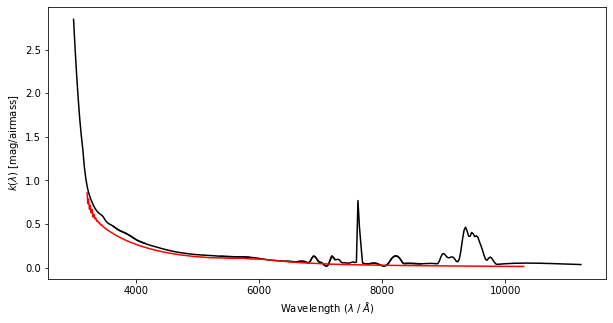

In [7]:
sdss_bands = ['u','g','r','i','z']
cfis_bands = ['U','G','R','I','Z']
cfis_path = 'Sources/utils/CFIS-cfg/CFIS_Photometry/'
sdss_path = 'Sources/utils/CFIS-cfg/SDSS_Photometry/'

fig,ax = plt.subplots(figsize=(10,5))

for band in sdss_bands:
    
    fileName = sdss_path+'{}.dat'.format(band)
    filterData = np.loadtxt(fileName)
    filter_wl, filter_res = filterData[:,0],filterData[:,4]
    ax.plot(filter_wl,-2.5*np.log10(filter_res),color='black')
    
fileName = cfis_path + 'CFIS_extinction.txt'
filter_wl,filter_res = np.loadtxt(fileName,unpack=True)
#filter_res = 10**(-0.4*(filter_res))
ax.plot(filter_wl,filter_res,color='red')
ax.set_xlabel(r'Wavelength ($\lambda$ / $\AA$)')
ax.set_ylabel('$k(\lambda)$ [mag/airmass]')

    

## Produce idealized synthetic CFIS images

Below I use a similar script to the one used for SDSS in the `RealSim` example notebook to produce CFIS images at a specific target redshift. I also test out the functionality of multiprocessing with the `SpecPhotCFIS` function. Very speedy.

In [1]:
#!/usr/bin/env python

import os,sys
from glob import glob
from SpecPhotCFIS import SpecPhotCFIS
import multiprocessing

# get cpu count
# SLURM_CPUS = int(os.environ['SLURM_JOB_CPUS_PER_NODE']) # for cluster
# get cpu count
SLURM_CPUS = 2

# base path to SKIRT datacubes
ifu_base_path = 'Inputs/Datacubes/'
# configuration path (SEx params, gim2d files, etc.)
cfis_cfg_path = 'Sources/utils/CFIS-cfg/CFIS_Photometry/'
# target redshift
redshift = 0.046

# list of SKIRT datacubes
ifuList = list(sorted(glob(ifu_base_path+'spec*.fits')))
# wavelength list from SKIRT
wl_filename = cfis_cfg_path+'SKIRT_wavelength_grid.dat'
# bands in which to produce photometry
bands = ['g','r','i']

if __name__ is '__main__':

    # produce argument list to send to function
    argList = []
    for ifuName in ifuList:
        _outputName = ifuName.replace(ifu_base_path,'Inputs/').replace('spec_','photo_{}_CFIS_')
        argList.append((ifuName,_outputName,wl_filename,cfis_cfg_path,redshift))
    argList = list(set(argList))

    # pool function application to argument list
    pool = multiprocessing.Pool(SLURM_CPUS)
    pool.starmap(SpecPhotCFIS, argList)
    pool.close()
    pool.join()


## Major adaptation to `ObsRealism.py`

Here I test the `ObsRealism.py` function for CFIS.

In [3]:
#!/bin/env python

import numpy as np
import os,sys,string,time,random
from rebin import rebin
import scipy.interpolate
import scipy.ndimage
from glob import glob
import warnings
from astropy.io import fits
from astropy.wcs import WCS
from astropy.utils.exceptions import AstropyWarning
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from astropy.cosmology import FlatLambdaCDM
import sep
sep.set_extract_pixstack(9999999)
from vos import vos

# RealSimCFIS base directory (should be part of `self` if class)
RSDIR = '/Users/cbottrell/Project/RealSimCFIS/'

def getInfo_SQL():
    '''Grab object and tile info from database.'''
    import pymysql
    cnf_path = '/Users/cbottrell/.mysql/lauca.cnf'
    db = pymysql.connect(host='lauca.phys.uvic.ca',
                         user='cbottrell',
                         database='sdss',
                         read_default_file=cnf_path)
    c = db.cursor()
    dbcmd = ['SELECT objID,ra,decl,CFIS_tile',
             'FROM dr7_uberuber',
             'WHERE in_CFIS_May2019=1']
    c.execute(' '.join(dbcmd))
    data = np.asarray(c.fetchall())
    c.close()
    db.close()
    objIDs = data[:,0].astype(int)
    ras = data[:,1].astype(float)
    decs = data[:,2].astype(float)
    tiles = data[:,3]
    return objIDs,ras,decs,tiles

def getInfo_File():
    '''Grab object and info from npy file.'''
    catName = RSDIR+'/Sources/Catalogues/CFIS-DR7_fieldInfo.npy'
    objIDs,ras,decs,tiles = np.load(catName)
    objIDs = objIDs.astype(int)
    ras = ras.astype(float)
    decs = decs.astype(float)
    return objIDs,ras,decs,tiles

def genCFIS_argList(use_sql=False):
    '''Generate CFIS argument list.'''
    if use_sql:
        objIDs,ras,decs,tiles = getInfo_SQL()
    else:
        objIDs,ras,decs,tiles = getInfo_File()
    return list(zip(ras,decs,tiles))

def getCutoutImage(ra,dec,tile,hw=1750):
    '''Get a large cutout of CFIS tile. Input images are 10000x10000.
    This function makes an (11 arcmin x 11 arcmin) of the CFIS tile. 
    It finds the (row,col) position of the target objID using ra,dec (degrees).
    It then checks for boundary conditions on the cutout region and adapts.
    The final cutout is 3501x3501 pixels, not always centered on the target.
    `hw` is the half-width of the cutout size. Returns cutout filename.'''
    warnings.filterwarnings('ignore')
    client = vos.Client()
    wcsName = 'WCS-{}'.format(tile)
    cutoutName = 'Cutout-{}'.format(tile)
    # get wcs file
    while not os.access(wcsName,0):
        try:
            client.copy(source='vos:cfis/tiles_DR2/{}[1:2,1:2]'.format(tile),
                        destination=wcsName)
        except:
            time.sleep(10)
    # get wcs mapping
    wcs = WCS(wcsName)
    # determine column and row position in image
    colc,rowc = wcs.all_world2pix(ra,dec,1,ra_dec_order=True)
    # convert to integers
    colc,rowc = int(np.around(colc)),int(np.around(rowc))
    # remove temporary file
    if os.access(wcsName,0): os.remove(wcsName)
    # get boundaries
    if colc - hw < 1:
        colc_m = 1
        colc_p = 2*hw+1
    elif colc + hw > 10000:
        colc_m = 10000-(2*hw)
        colc_p = 10000
    else:
        colc_m = colc-hw
        colc_p = colc+hw
    if rowc - hw < 1:
        rowc_m = 1
        rowc_p = 2*hw+1
    elif rowc + hw > 10000:
        rowc_p = 10000
        rowc_m = 10000-(2*hw)
    else:
        rowc_m = rowc-hw
        rowc_p = rowc+hw
    # get full file
    while not os.access(cutoutName,0):
        try:
            client.copy(source='vos:cfis/tiles_DR2/{}[{}:{},{}:{}]'.format(tile,colc_m,colc_p,rowc_m,rowc_p),
                        destination=cutoutName)
        except:
            time.sleep(10)
    return cutoutName

def genSegmap(cutoutName):
    '''Create segmenation image using the sep SExtractor module.'''
    cutoutData = fits.getdata(cutoutName)
    # filter kernel
    filter_kernel = np.loadtxt('{}Sources/utils/CFIS-cfg/gauss_3.0_7x7.conv'.format(RSDIR),skiprows=2)
    # use std of full image as detection threshold
    guess_rms = np.std(cutoutData)
    # mask all sources above std for background statistics
    mask = (cutoutData>guess_rms)
    # https://github.com/kbarbary/sep/issues/23
    cutoutData_sw = cutoutData.byteswap(True).newbyteorder()
    # bkg object which includes sky() and rms() methods
    bkg = sep.Background(cutoutData_sw, mask=mask, bw=32, bh=32, fw=3, fh=3)
    # run sep.extract() on image
    objCat,segmap = sep.extract(cutoutData_sw, thresh=1.0, err=bkg.rms(), mask=None, minarea=5,
                             filter_kernel=filter_kernel,filter_type='conv',deblend_nthresh=32,
                             deblend_cont=0.001, clean=True,clean_param=1.0, segmentation_map=True)
    return segmap
    
def getInjectCoords(segmap):
    '''Use segmentation image to find injection coordinates.
    There is a 10% boundary from the cutout edges which are forbidden.
    A pixels that is both a sky pixel and is inside the boundary is eligible.'''
    # always square cutouts
    size = segmap.shape[0]
    # background pixels
    bkgmap = (segmap == 0)
    # pixels within 10% of image size from either side
    bordermap = np.zeros(segmap.shape)
    bordermap[int(0.1*size):int(0.9*size),int(0.1*size):int(0.9*size)]=1
    # map of possible injection sites
    segmap = bordermap*bkgmap
    # index of injection site for map
    index = np.random.choice(int(np.sum(segmap)))
    # coordinates of injection site 
    return np.argwhere(segmap)[index]

def RealSim_CFIS(inputName,outputName,
                 cosmo=FlatLambdaCDM(H0=70,Om0=0.3), # cosmology
                 redshift       = 0.05,   # mock observation redshift
                 apply_dimming  = False,  # apply redshift dimming 
                 rebin_to_CCD   = True,   # rebin to CCD angular scale
                 CCD_scale      = 0.187,  # CCD angular scale in [arcsec/pixel]
                 add_false_sky  = False,  # add gaussian sky
                 false_sky_sig  = 24.2,   # gaussian sky standard dev [AB mag/arcsec2]
                 add_false_psf  = True,   # convolve with gaussian psf
                 false_psf_fwhm = 0.6,    # gaussian psf FWHM [arcsec]
                 add_poisson    = False,  # add poisson noise to galaxy
                 add_cfis_sky   = True,   # insert into real CFIS sky (using sdss_args)
                ):

    # speed of light [m/s]
    speed_of_light = 2.99792458e8
    # kiloparsec per arcsecond scale
    kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z=redshift).value/60. # [kpc/arcsec]
    # luminosity distance in Mpc
    luminosity_distance = cosmo.luminosity_distance(z=redshift) # [Mpc]
    
    # img header and data
    with fits.open(inputName,mode='readonly') as hdul:
        # img header
        header = hdul[0].header
        # img data
        img_data = hdul[0].data
        
    # collect physical pixel scale
    kpc_per_pixel = header['CDELT1']/1000. # [kpc/pixel]
    # compute angular pixel scale from cosmology
    arcsec_per_pixel = kpc_per_pixel / kpc_per_arcsec # [arcsec/pixel]
     
    # img in AB nanomaggies per arcsec2
    img_nanomaggies = 10**(-0.4*(img_data-22.5)) # [nmgys/arcsec2]
    # if not already dimmed, apply here
    if apply_dimming:
        img_nanomaggies*=(1+redshift)**(-5)
    # apply pixel scale [arcsec/pixel]2 to convert to calibrated flux
    img_nanomaggies *= arcsec_per_pixel**2 # [nmgs]
    # update units of image header to linear calibrated scale
    header['BUNIT'] = 'AB nanomaggies'
    
    # Add levels of realism
    if rebin_to_CCD:
        '''
        Rebin image to a given angular CCD scale
        '''
        # telescope ccd angular scale
        ccd_scale = CCD_scale
        # axes of original image
        nPixelsOld = img_nanomaggies.shape[0]
        # axes of regridded image
        nPixelsNew = int(np.floor((arcsec_per_pixel/ccd_scale)*nPixelsOld))
        # rebin to new ccd scale
        img_nanomaggies = rebin(img_nanomaggies,(nPixelsNew,nPixelsNew))
        # new kpc_per_pixel on ccd
        kpc_per_pixel = kpc_per_arcsec * ccd_scale
        # new arcsec per pixel
        arcsec_per_pixel = ccd_scale
        # header updates
        if nPixelsNew%2: CRPIX = float(nPixelsNew/2)
        else: CRPIX = float(nPixelsNew/2)+0.5
        header['CRPIX1'] = CRPIX
        header['CRPIX2'] = CRPIX
        header['CDELT1'] = kpc_per_pixel*1000
        header['CDELT2'] = kpc_per_pixel*1000
        
    # convolve with gaussian psf
    if add_false_psf:
        '''
        Add Gaussian PSF to image with provided FWHM in
        arcseconds.
        '''
        std = false_psf_fwhm/arcsec_per_pixel/2.355
        kernel = Gaussian2DKernel(x_stddev=std,y_stddev=std)
        img_nanomaggies = convolve(img_nanomaggies, kernel)
        
        # add poisson noise to image
    if add_poisson and not add_cfis_sky:
        '''
        Add shot noise to image assuming the average SDSS
        field properties for zeropoint, airmass, atmospheric
        extinction, and gain. The noise calculation assumes
        that the number of counts in the converted image is 
        the mean number of counts in the Poisson distribution.
        Thereby, the standard error in that number of counts 
        is the square root of the number of counts in each 
        pixel.
        
        !!! Needs change for CFIS.
        '''
        # !!! average CFIS photometric field properties (gain is inverse gain)
        airmass  = {'u':1.178, 'g':1.178, 'r':1.177, 'i':1.177, 'z':1.178}
        aa       = {'u':-23.80,'g':-24.44,'r':-24.03,'i':-23.67,'z':-21.98}
        kk       = {'u':0.5082,'g':0.1898,'r':0.1032,'i':0.0612,'z':0.0587}
        gain     = {'u':1.680, 'g':3.850, 'r':4.735, 'i':5.111, 'z':4.622}
        exptime  = 53.907456 # seconds
        # conversion factor from nanomaggies to counts
        counts_per_nanomaggy = exptime*10**(-0.4*(22.5+aa[band]+kk[band]*airmass[band]))
        # image in counts for given field properties
        img_counts = np.clip(img_nanomaggies * counts_per_nanomaggy,a_min=0,a_max=None)
        # poisson noise [adu] computed accounting for gain [e/adu]
        img_counts = np.random.poisson(lam=img_counts*gain[band])/gain[band]
        # convert back to nanomaggies
        img_nanomaggies = img_counts / counts_per_nanomaggy
        
    # add gaussian sky to image
    if add_false_sky:
        '''
        Add sky with noise level set by "false_sky_sig" 
        keyword. "false_sky_sig" should be in relative  
        AB magnitudes/arcsec2 units. In other words,
        10**(-0.4*false_sky_sig) gives the sample 
        standard deviation in the sky in linear flux units
        [maggies/arcsec2] around a sky level of zero.
        '''
        # conversion from mag/arcsec2 to nanomaggies/arcsec2
        false_sky_sig = 10**(0.4*(22.5-false_sky_sig))
        # account for pixel scale in final image
        false_sky_sig *= arcsec_per_pixel**2
        # create false sky image
        sky = false_sky_sig*np.random.randn(*img_nanomaggies.shape)
        # add false sky to image in nanomaggies
        img_nanomaggies += sky
        header.append(('SKY',0.0,'Average sky in full CFIS tile [nanomaggies]'),end=True)
        header.append(('SKYSIG',false_sky_sig,'Average sky uncertainty per pixel [nanomaggies]'),end=True)
        
    if add_cfis_sky:
        cfis_argList = genCFIS_argList(use_sql=False)
        ra,dec,tile = random.choice(cfis_argList)
        cutoutName = getCutoutImage(ra,dec,tile)
        # cutout data, converted from counts/s (AB zeropoint=30) to nanomaggies
        cutoutData = fits.getdata(cutoutName)*10**(-0.4*(30-22.5))
        # segmentation map
        segMap = genSegmap(cutoutName)
        # injection coords
        colc,rowc = getInjectCoords(segMap)
        
        # add real sky pixel by pixel to image in nanomaggies
        corr_ny,corr_nx = cutoutData.shape
        ny,nx = img_nanomaggies.shape
        for xx in range(nx):
            for yy in range(ny):
                corr_x = int(colc - nx/2 + xx)
                corr_y = int(rowc - ny/2 + yy)
                if corr_x>=0 and corr_x<=corr_nx-1 and corr_y>=0 and corr_y<=corr_ny-1:
                    img_nanomaggies[yy,xx]+=cutoutData[corr_y,corr_x]
                else:
                    img_nanomaggies[yy,xx]=0.
        if os.access(cutoutName,0):os.remove(cutoutName)
        # add field info to image header
        warnings.simplefilter('ignore', category=AstropyWarning)            
        header.append(('TILE',tile,'CFIS tile ID'),end=True)
        header.append(('RA',float(ra),'Cutout centroid RA'),end=True)
        header.append(('DEC',float(dec),'Cutout centroid DEC'),end=True)
        header.append(('COLC',colc,'CFIS tile column center'),end=True)
        header.append(('ROWC',rowc,'CFIS tile row center'),end=True)
        header.append(('GAIN','N/A','CFIS CCD GAIN'),end=True)
        header.append(('ZERO',30.0,'CFIS image zeropoint'),end=True)
        header.append(('EXTC','N/A','CFIS image atm. extinction coefficient'),end=True)
        header.append(('AIRM','N/A','CFIS image airmass'),end=True)
        header.append(('SKY',-999,'Average sky in full CFIS tile [nanomaggies]'),end=True)
        header.append(('SKYSIG',-999,'Average sky uncertainty per pixel [nanomaggies]'),end=True)
        
    if os.access(outputName,0): os.remove(outputName)
    hdu_pri = fits.PrimaryHDU(img_nanomaggies)
    header['REDSHIFT'] = (redshift,'Redshift')
    header.append(('COSMO','FLAT_LCDM','Cosmology'),end=True)
    header.append(('OMEGA_M',cosmo.Om(0),'Matter density'),end=True)
    header.append(('OMEGA_L',cosmo.Ode(0),'Dark energy density'),end=True)
    header.append(('SCALE_1',arcsec_per_pixel,'[arcsec/pixel]'),end=True)
    header.append(('SCALE_2',kpc_per_pixel,'[kpc/pixel]'),end=True)
    header.append(('SCALE_3',kpc_per_arcsec,'[kpc/arcsec]'),end=True)
    header.append(('LUMDIST',cosmo.luminosity_distance(z=redshift).value,'Luminosity Distance [Mpc]'),end=True)
    warnings.simplefilter('ignore', category=AstropyWarning)
    header.append(('apply_dimming', apply_dimming),end=True)
    header.append(('rebin_to_CCD', rebin_to_CCD),end=True)
    header.append(('CCD_scale', CCD_scale),end=True)
    header.append(('add_false_sky', add_false_sky),end=True)
    header.append(('false_sky_sig ', false_sky_sig),end=True)
    header.append(('add_false_psf', add_false_psf),end=True)
    header.append(('false_psf_fwhm', false_psf_fwhm),end=True)
    header.append(('add_poisson', add_poisson),end=True)
    header.append(('add_cfis_sky', add_cfis_sky),end=True)
    hdu_pri.header = header
    hdu_pri.writeto(outputName)
    
def worker_wrapper(arg):
    inputName,outputName,common_args = arg
    if not os.access(outputName,0):
        with tempfile.TemporaryDirectory() as path:
            os.chdir(path)
            RealSim_CFIS(inputName,outputName,**common_args)

def main(fov_per_image=1):
    
    SLURM_CPUS = mp.cpu_count()
    pool = mp.Pool(1)
    
    inputList = list(sorted(glob('{}Inputs/photo_r_CFIS*.fits'.format(RSDIR))))

    cosmo=FlatLambdaCDM(H0=70,Om0=0.3)
    common_args = { 
                'redshift'      : 0.05, # mock observation redshift
                'apply_dimming' : False, # apply redshift dimming 
                'rebin_to_CCD'  : True, # rebin to CCD angular scale
                'CCD_scale'     : 0.187, # CCD angular scale in [arcsec/pixel]
                'add_false_sky' : False, # add gaussian sky
                'false_sky_sig' : 24.2,  # gaussian sky standard dev [AB mag/arcsec2]
                'add_false_psf' : True, # convolve with gaussian psf
                'false_psf_fwhm': 0.6,   # gaussian psf FWHM [arcsec]
                'add_poisson'   : False, # add poisson noise to galaxy
                'add_cfis_sky'  : True, # insert into real CFIS sky (using sdss_args)
                    }

    # create argument list
    argList = []
    for inputName in inputList:
        for image_i in range(fov_per_image):
            outputName = inputName.replace('.fits','_FullReal-{}.fits'.format(image_i)).replace('Inputs/','Outputs/')
            argList.append((inputName,outputName,common_args))
    
    pool.map(worker_wrapper, argList)
    pool.close()
    pool.join()
    
if __name__ == '__main__':
    import time,tempfile
    import multiprocessing as mp
    main(fov_per_image=11)

## Using the new package

I apply the package to generate 10 random fields for each image in the `Inputs` directory.

In [1]:
from ObsRealism import *
import numpy as np
import os,sys,string,time,random

def worker_wrapper(arg):
    np.random.seed()
    random.seed()
    inputName,outputName,common_args = arg
    if not os.access(outputName,0):
        with tempfile.TemporaryDirectory() as path:
            os.chdir(path)
            RealSim_CFIS(inputName,outputName,**common_args)

def main(fov_per_image=1):
    
    from glob import glob
    SLURM_CPUS = mp.cpu_count()

    pool = mp.Pool(SLURM_CPUS)
    
    inputList = list(sorted(glob('{}Inputs/photo_r_CFIS*.fits'.format(RSDIR))))

    cosmo=FlatLambdaCDM(H0=70,Om0=0.3)
    common_args = { 
                'redshift'      : 0.05, # mock observation redshift
                'apply_dimming' : False, # apply redshift dimming 
                'rebin_to_CCD'  : True, # rebin to CCD angular scale
                'CCD_scale'     : 0.187, # CCD angular scale in [arcsec/pixel]
                'add_false_sky' : False, # add gaussian sky
                'false_sky_sig' : 24.2,  # gaussian sky standard dev [AB mag/arcsec2]
                'add_false_psf' : True, # convolve with gaussian psf
                'false_psf_fwhm': 0.6,   # gaussian psf FWHM [arcsec]
                'add_poisson'   : False, # add poisson noise to galaxy
                'add_cfis_sky'  : True, # insert into real CFIS sky (using sdss_args)
                    }

    # create argument list
    argList = []
    for inputName in inputList:
        for image_i in range(fov_per_image):
            outputName = inputName.replace('.fits','_FullReal-{}.fits'.format(image_i)).replace('Inputs/','Outputs/')
            argList.append((inputName,outputName,common_args))
    
    pool.map(worker_wrapper, argList)
    pool.close()
    pool.join()
    
if __name__ == '__main__':
    import time,tempfile
    import multiprocessing as mp
    main(fov_per_image=10)

## Plotting output

Output images for a single snapshot/camera angle in 10 random fields.

/Users/cbottrell/anaconda3/envs/cfis/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':


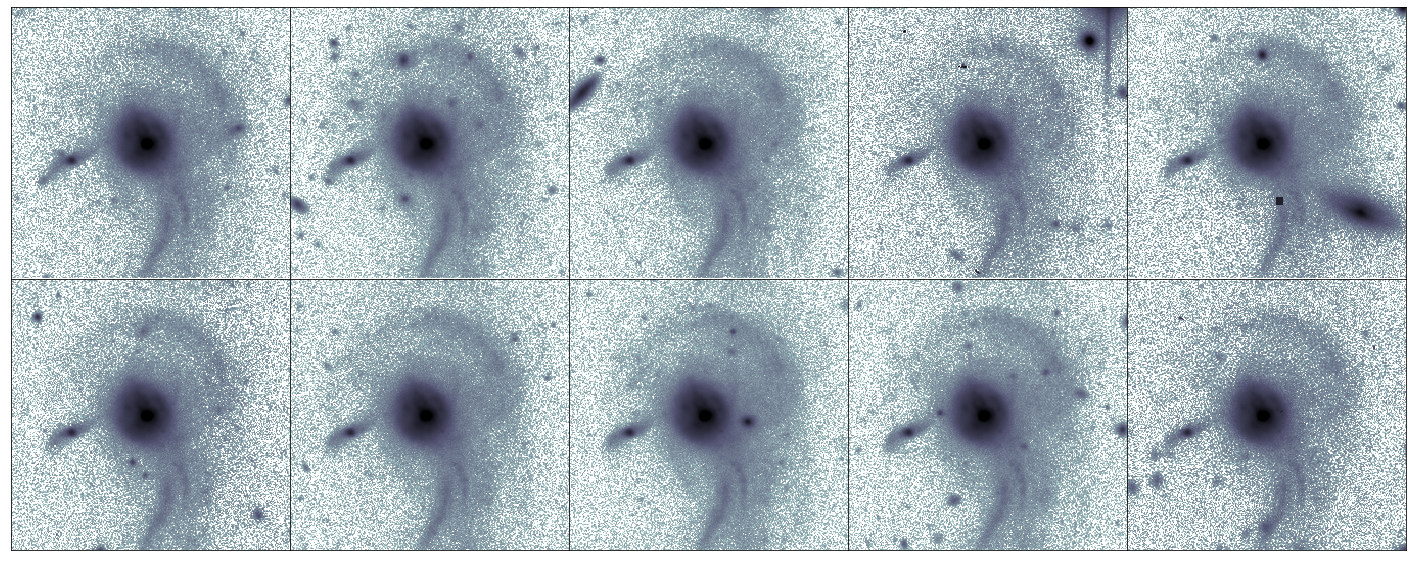

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob

fig,axarr = plt.subplots(2,5,figsize=(25,10))
fig.subplots_adjust(wspace=0.,hspace=0.)
axarr = axarr.flatten()

imgList = glob('Outputs/*.fits')

for ii,imgName in enumerate(imgList):
    axarr[ii].imshow(np.log10(fits.getdata(imgName)),vmin=-4,vmax=0,cmap='bone_r',origin='lower',aspect='auto')
    axarr[ii].get_xaxis().set_visible(False)
    axarr[ii].get_yaxis().set_visible(False)